'\n    This gives values of alpha = 22.95 and beta = 0.903. So our model says that we expect a user with n friends to spend 22.95 + n * 0.903 minutes on the site each day. That is, we predict that a user with no friends on DataSciencester would spend about 23 min a day on the site. And for each additional friend, we expect a user to spend almost a minute more on the site each day.\n'

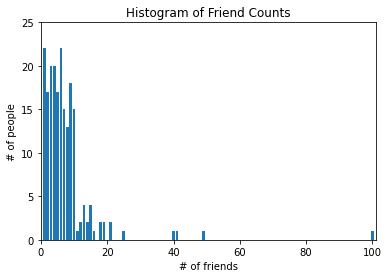

In [6]:
#The Model

'''
    The VP of Engagement asks you to build a model describing the relationship between number of friends and time spent on the site. Since you found a pretty strong linear relationship, a natural place to start is a linear model.
    In particular, you hypotesize that there are constants α and β such that:
    
        yi = βxi + α + εi
    
    Where yi is the number of minutes user i spends on the site daily, xi is the number of friends user i has, and ε is a (hopefully small) error term representing the fact that there are other factors not accounted for by this simple model.
    Assuming we've determined such an alpha and beta, then we make predictions simple with:
'''

def predict(alpha: float, beta: float, x_i: float) -> float:
    return beta * x_i + alpha

'''
    How do we chose alpha and beta? Well, any choice of alpha and beta gives us a predicted output for each input x_i. Since we know the actual output y_i, we can compute the error for each pair:
'''

def error(alpha: float, beta: float, x_i: float, y_i: float) -> float:
    """
    The error from predicting beta + x_i + alpha
    when the actual value is y_i
    """
    return predict(alpha,beta,x_i) - y_i

'''
    What we'd really like to know is the total error over the entire dataset. But we don't want to just add the errors - if the prediction for x_1 is too high and the prediction for x_2 is too low, the errors may just cancel out.
    So instead we add up the squared errors:
'''

from scratch.linear_algebra import Vector

def sum_of_sqerrors(alpha: float, beta: float, x: Vector, y: Vector) -> float:
    return sum(error(alpha, beta, x_i, y_i) ** 2 for x_i, y_i in zip(x,y))

'''
    The least squares solution is to choose the alpha and beta that make sum_of_sqerrors as small as possible
    Using calculus (or tedious algebra), the error-minimizing alpha and beta are given by:
'''

from typing import Tuple
from scratch.linear_algebra import Vector
from scratch.statistics import correlation, standard_deviation, mean

def least_squares_fit(x: Vector, y: Vector) -> Tuple[float, float]:
    """
    Given two vectors x and y
    find the least-squares values of alpha and beta
    """
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta

#A quick test

x = [i for i in range (-100, 110, 10)]
y = [3 * i - 5 for i in x]

#Should find that y = 3x - 5
assert least_squares_fit(x, y) == (-5, 3)

#Now it's easy to apply this to the outlierless data from chp 5

from scratch.statistics import num_friends_good, daily_minutes_good

alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)
assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905

'''
    This gives values of alpha = 22.95 and beta = 0.903. So our model says that we expect a user with n friends to spend 22.95 + n * 0.903 minutes on the site each day. That is, we predict that a user with no friends on DataSciencester would spend about 23 min a day on the site. And for each additional friend, we expect a user to spend almost a minute more on the site each day.
'''

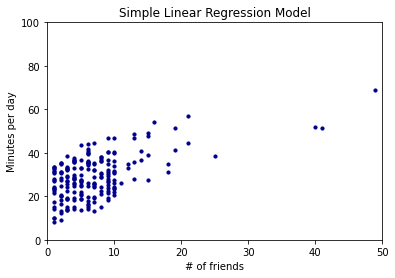

In [7]:
#(Solo) Trying to replicate graph from textbook F14-1
from matplotlib import pyplot as plt 

plt.scatter(num_friends_good, daily_minutes_good, s = 10, c="darkblue")
plt.axis([0, 50, 0, 100])

plt.title("Simple Linear Regression Model")
plt.xlabel("# of friends")
plt.ylabel("Minutes per day")
plt.show()
#Don't know how to get the average line 

In [8]:
'''
    Of course, we need a better way to figure out how well we've fit the data than staring at the graph. A common measure is the coefficient of determination (or R-squared), which measures the fraction of the total variation in the dependent variable that is captures by the model:
'''

from scratch.statistics import de_mean

def total_sum_of_squares(y: Vector) -> float:
    """the total squared variation of y_i's from their mean"""
    return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha: float, beta: float, x: Vector, y: Vector) -> float:
    """
    The fraction of variation in y captured in y captured by the model, which equal 1 - the fraction of variation in y not captured by the model
    """
    return 1.0 - (sum_of_sqerrors(alpha, beta, x, y) / total_sum_of_squares(y))

rsq = r_squared(alpha, beta, num_friends_good, daily_minutes_good)
assert 0.328 < rsq < 0.330

#   Recall that we chose the alpha and beta that minimized the sum of the squared prediction errors. A linear model we could have chosen is "always predict mean(y" (corresponding to alpha = mean(y) and beta = 0), whose sum of squared errors exactly equals its total sum of squares. This means an R-squared of 0, which indicates a model that (obviously, in this case) performs no better than just predicting the mean.
#   Clearly, the least squares model muist be at least as good as that one, which means that the sum of the squared errors is at most the total sum of squares, which means that the R-squared must be at least 0. And the sum of squared errors must be at least 0, which means that the R-squared can be at most 1
#   The higher the number, the better our model fits the data. Here we calculate an R-squared of 0.329, which tells us that our models is only sort of okay at fitting the data, and that clearly there are other factors at play 

In [12]:
#Using Gradient Descent

#If we write theta = [alpha, beta], we can also solve this using gradient descent
import random
import tqdm
from scratch.gradient_descent import gradient_step

num_epochs = 10000
random.seed(0)

guess = [random.random(), random.random()] #Choose random value to start

learning_rate = 0.00001

with tqdm.trange(num_epochs) as t:
    for _ in t:
        alpha, beta = guess

        #Partial derivative of loss with repsect to alpha
        grad_a = sum(2 * error(alpha, beta, x_i, y_i)
                        for x_i, y_i in zip(num_friends_good, daily_minutes_good))

        #Partial derivative of loss with repsect to beta
        grad_b = sum(2 * error(alpha, beta, x_i, y_i) * x_i
                        for x_i, y_i in zip(num_friends_good, daily_minutes_good))

        #Compute loss to stick in the tqdm description
        loss = sum_of_sqerrors(alpha, beta, num_friends_good, daily_minutes_good)
        t.set_description(f"loss: {loss:.3f}")

        #Finally, update the guess
        guess = gradient_step(guess, [grad_a, grad_b], -learning_rate)

    #We should get pretty much the same results
    alpha, beta = guess
    assert 22.9 < alpha < 23.0
    assert 0.9 < beta < 0.905

loss: 13196.619: 100%|██████████| 10000/10000 [00:09<00:00, 1075.24it/s]


In [1]:
#Maximum Likelihood Estimation
'''
    Why choose least squares? One justification invloves maximum likelihood estimation. Imagine that we have a sample of data v1, ..., vn that comes from a distribution that depends on some unknown parameters θ:
        p(v1, ..., vn | θ)

    If we didn't know θ, we could turn around and think of this quantity as the likelihood of θ given the sample:
        L(θ | v1, ..., vn)
    
    Under this approach, the most likely θ is the value that maximizes this likelihood function -- that is, the value that makes the observed data the most probable. In the case of a continuous distribution, in which we have a probability distribution function rather than a probability mass function, we can do the same thing.
    Back to regression. One assumption that's often made about the simple regression model is that the regression errors are normally distributed with mean 0 and some (known) standard deviation σ. If that's the case, then the likelihood based on seeing a pair (x_i, y_i) is:
        L(α, β | xi, yi, σ) = 1/sqrt(2piσ) exp (-(yi-α − βxi)^2/2σ^2)
    
    The likelihood based on the entire dataset is the product of the individual likelihoods, which is largest precisely when alpha and beta are choosen to minimize the sum of squared errors. That is, in this case (with these assumptions), minimizing the sum of squared errors is equivalent to maximizing the likelihood of the observed data.
'''

"\n    Why choose least squares? One justification invloves maximum likelihood estimation. Imagine that we have a sample of data v1, ..., vn that comes from a distribution that depends on some unknown parameters θ:\n        p(v1, ..., vn | θ)\n\n    If we didn't know θ, we could turn around and think of this quantity as the likelihood of θ given the sample:\n        L(θ | v1, ..., vn)\n    \n    Under this approach, the most likely θ is the value that maximizes this likelihood function -- that is, the value that makes the observed data the most probable. In the case of a continuous distribution, in which we have a probability distribution function rather than a probability mass function, we can do the same thing.\n    Back to regression. One assumption that's often made about the simple regression model is that the regression errors are normally distributed with mean 0 and some (known) standard deviation σ. If that's the case, then the likelihood based on seeing a pair (x_i, y_i) is:\n